# 07: ML vs likelihood comparison 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
plt.rcParams.update({'pgf.texsystem':'pdflatex'})
import numpy as np
import SMEFT19
from flavio.statistics.functions import delta_chi2
from SMEFT19.utils import listpoint
import flavio.plots.colors
import scipy

In [8]:
mlpoints = pd.read_csv('../data/samples/mlpoints.dat', sep='\t')

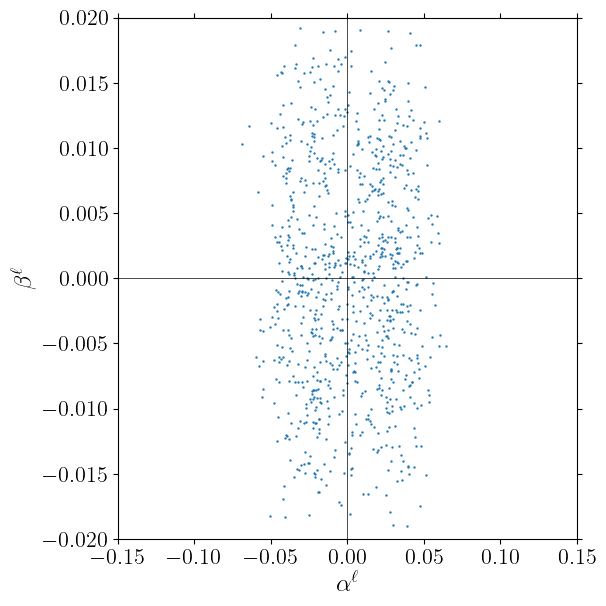

In [36]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mlpoints['al'], mlpoints['bl'], s=0.5)
plt.xlim([-0.15, 0.15])
plt.ylim([-0.02, 0.02])
plt.xlabel(r'$\alpha^\ell$', fontsize=18)
plt.ylabel(r'$\beta^\ell$', fontsize=18)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
ax = fig.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/ml_albl.pdf')

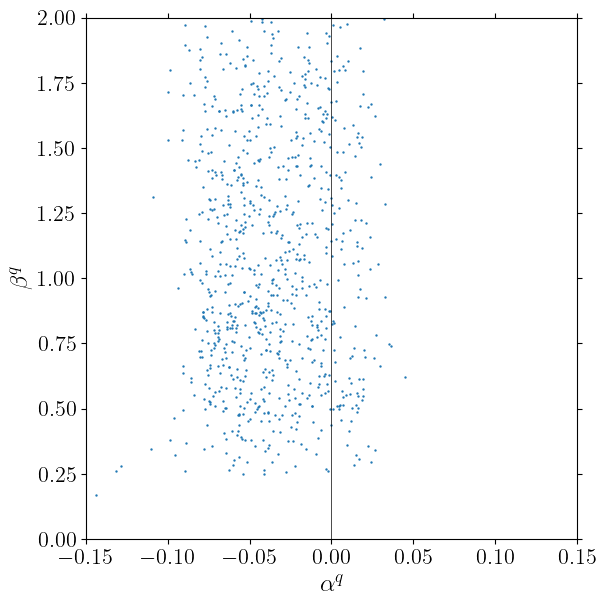

In [37]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mlpoints['aq'], mlpoints['bq'], s=0.5)
plt.xlim([-0.15, 0.15])
plt.ylim([0.0, 2.0])
plt.xlabel(r'$\alpha^q$', fontsize=18)
plt.ylabel(r'$\beta^q$', fontsize=18)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
ax = fig.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/ml_aqbq.pdf')

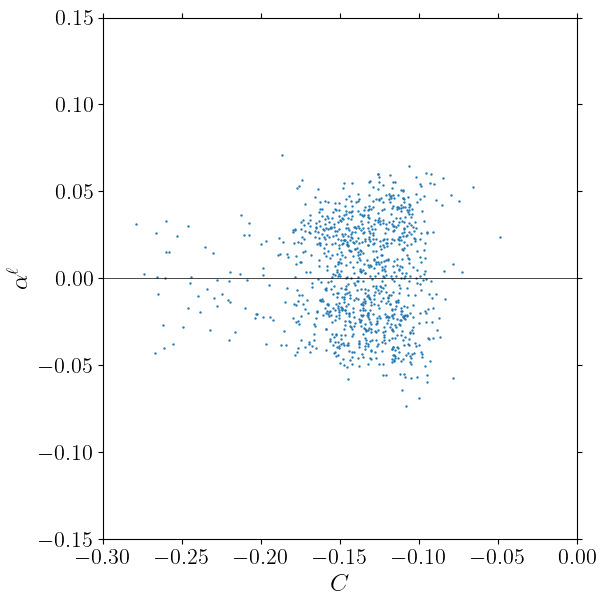

In [38]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mlpoints['C'], mlpoints['al'], s=0.5)
plt.xlim([-0.3, 0.0])
plt.ylim([-0.15, 0.15])
plt.ylabel(r'$\alpha^\ell$', fontsize=18)
plt.xlabel(r'$C$', fontsize=18)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
ax = fig.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/ml_Cal.pdf')

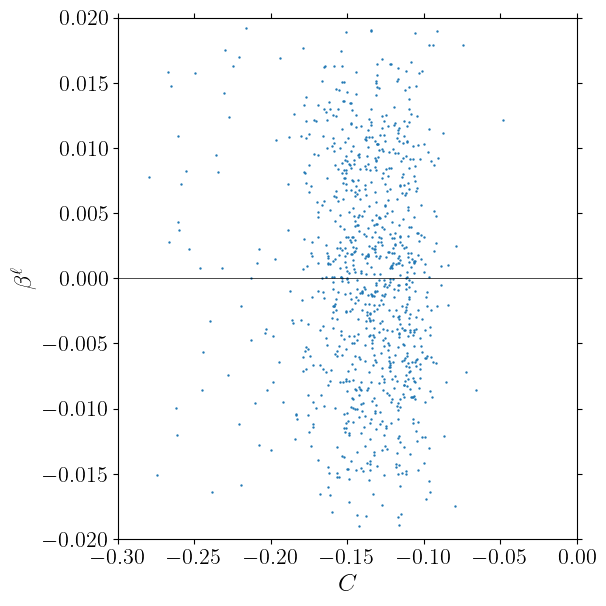

In [39]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mlpoints['C'], mlpoints['bl'], s=0.5)
plt.xlim([-0.3, 0.0])
plt.ylim([-0.02, 0.02])
plt.ylabel(r'$\beta^\ell$', fontsize=18)
plt.xlabel(r'$C$', fontsize=18)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
ax = fig.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/ml_Cbl.pdf')

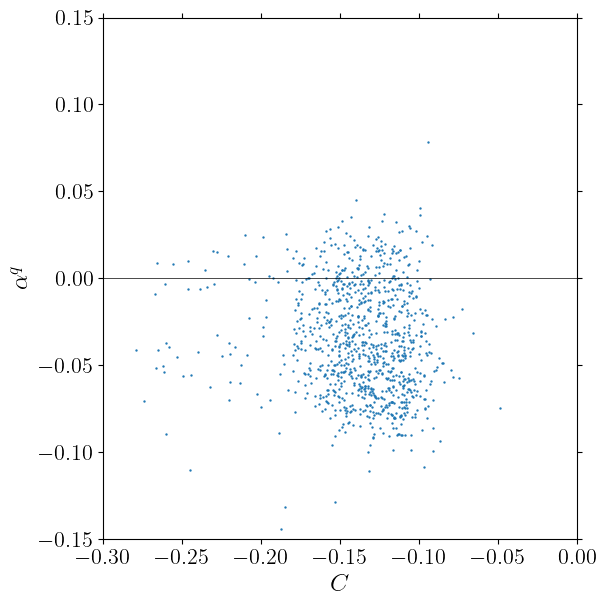

In [40]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mlpoints['C'], mlpoints['aq'], s=0.5)
plt.xlim([-0.3, 0.0])
plt.ylim([-0.15, 0.15])
plt.ylabel(r'$\alpha^q$', fontsize=18)
plt.xlabel(r'$C$', fontsize=18)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
ax = fig.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/ml_Caq.pdf')

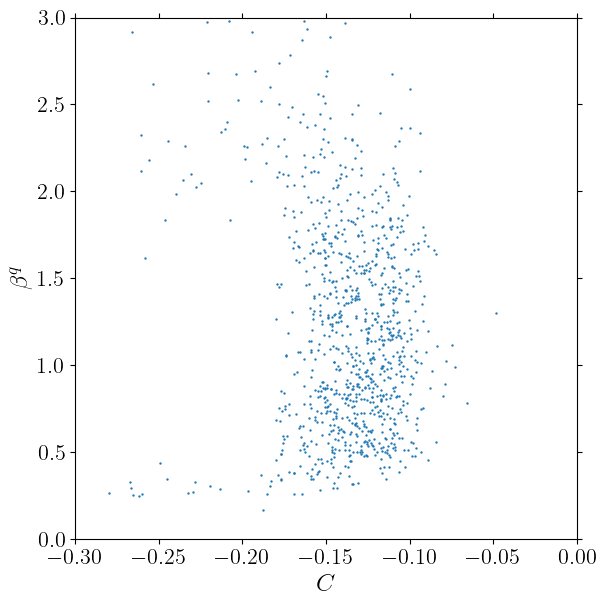

In [41]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mlpoints['C'], mlpoints['bq'], s=0.5)
plt.xlim([-0.3, 0.0])
plt.ylim([0.0, 3.0])
plt.ylabel(r'$\beta^q$', fontsize=18)
plt.xlabel(r'$C$', fontsize=18)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
ax = fig.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/ml_Cbq.pdf')

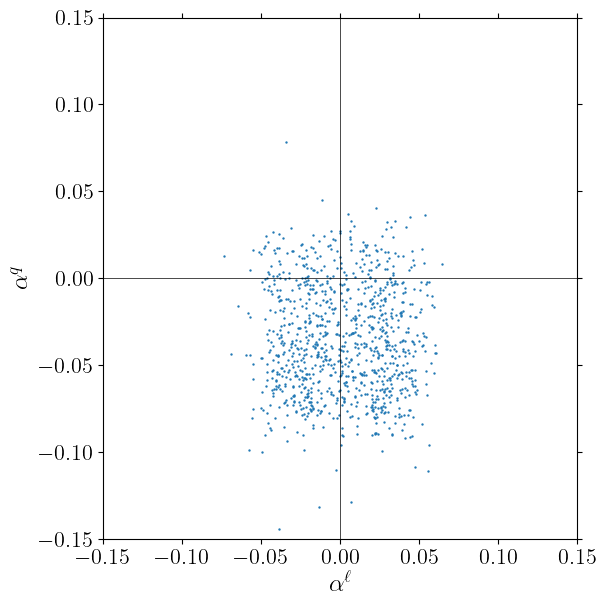

In [42]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mlpoints['al'], mlpoints['aq'], s=0.5)
plt.xlim([-0.15, 0.15])
plt.ylim([-0.15, 0.15])
plt.xlabel(r'$\alpha^\ell$', fontsize=18)
plt.ylabel(r'$\alpha^q$', fontsize=18)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
ax = fig.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/ml_alaq.pdf')

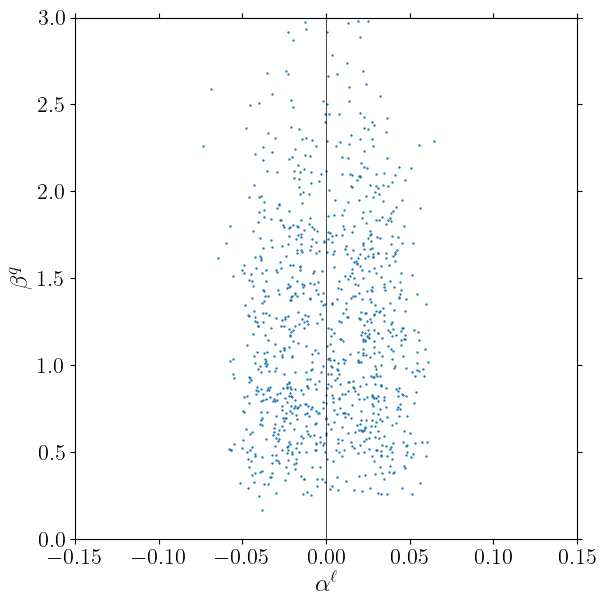

In [43]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mlpoints['al'], mlpoints['bq'], s=0.5)
plt.xlim([-0.15, 0.15])
plt.ylim([0.0, 3.0])
plt.xlabel(r'$\alpha^\ell$', fontsize=18)
plt.ylabel(r'$\beta^q$', fontsize=18)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
ax = fig.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/ml_albq.pdf')

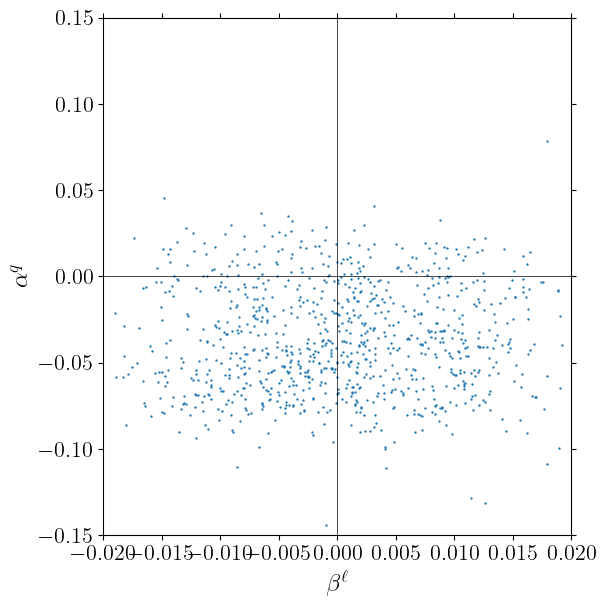

In [44]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mlpoints['bl'], mlpoints['aq'], s=0.5)
plt.xlim([-0.02, 0.02])
plt.ylim([-0.15, 0.15])
plt.xlabel(r'$\beta^\ell$', fontsize=18)
plt.ylabel(r'$\alpha^q$', fontsize=18)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
ax = fig.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/ml_blaq.pdf')

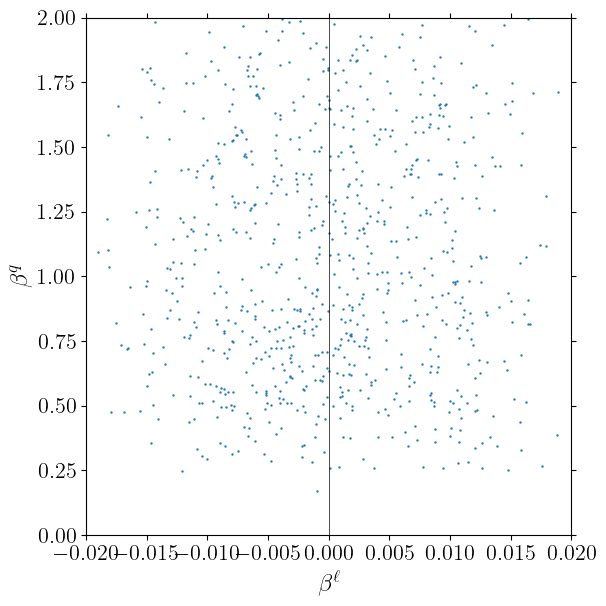

In [45]:
fig = plt.figure(figsize=(6,6))
plt.scatter(mlpoints['bl'], mlpoints['bq'], s=0.5)
plt.xlim([-0.02, 0.02])
plt.ylim([0, 2.0])
plt.xlabel(r'$\beta^\ell$', fontsize=18)
plt.ylabel(r'$\beta^q$', fontsize=18)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
ax = fig.gca()
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/ml_blbq.pdf')

In [2]:
dim_min = [-0.3, -0.15, -0.02, -0.15, 0]
dim_max = [0, 0.15, 0.02, 0.15, 3.0]

coefs = ['C', 'al', 'bl', 'aq', 'bq']

In [71]:
def read_meshgrid(par_x, par_y, n=30):
    index_x = coefs.index(par_x)
    index_y = coefs.index(par_y)
    xcoords = np.linspace(dim_min[index_x], dim_max[index_x], n)
    ycoords = np.linspace(dim_min[index_y], dim_max[index_y], n)
    glob = pd.read_csv(f"../data/likelihood/likelihood_rotBII_{par_x}{par_y}.dat", sep = '\t', header=None).values.T
    return (xcoords, ycoords, {'Global likelihood': glob})

In [4]:
d_ell = SMEFT19.ellipse.load('../data/ellipses/rotBII.yaml')
bf1 = d_ell['bf']

In [5]:
def hatch_contour2(x, y, z, levels, interpolation_factor=1, interpolation_order=2, col=0,
                  label=None, hatched=True, contour_args=None, contourf_args=None):
    r"""
Plots coloured and hatched confidence contours (or bands) given numerical
input arrays.Based on the `flavio` function
:Arguments:
    - x, y\: 2D arrays containg x and y values as returned by numpy.meshgrid
    - z\: value of the function to plot. 2D array in the same shape as `x` and
      `y`. The lowest value of the function should be 0 (i.e. the best fit point).
    - levels\: list of function values where to draw the contours. They should
      be positive and in ascending order.
    - [interpolation factor\:: in between the points on the grid,
      the functioncan be interpolated to get smoother contours.
      This parameter sets the number of subdivisions (default: 1, i.e. no
      interpolation). It should be larger than 1.]
    - [col\: number between 0 and 9 to choose the color of the plot
      from a predefined palette.]
    - [label\: label that will be added to a legend created with `maplotlib.pyplot.legend()`.]
    - [contour_args\: dictionary of additional options that will be passed to
      `matplotlib.pyplot.contour()` (that draws the contour lines).]
    - [contourf_args\: dictionary of additional options that will be passed to
      `matplotlib.pyplot.contourf()` (that paints the contour filling).]
    """
    contour_args = contour_args or {}
    contourf_args = contour_args or {}
    if interpolation_factor > 1:
        x = scipy.ndimage.zoom(x, zoom=interpolation_factor, order=1)
        y = scipy.ndimage.zoom(y, zoom=interpolation_factor, order=1)
        z = scipy.ndimage.zoom(z, zoom=interpolation_factor, order=interpolation_order)
    if isinstance(col, int):
        _contour_args = {}
        _contourf_args = {}
        _contour_args['colors'] = [flavio.plots.colors.set1[col]]
        _contour_args['linewidths'] = 1.2
        N = len(levels)
        _contourf_args['colors'] = [flavio.plots.colors.pastel[col] +
                                    (max(1-n/(N+1), 0),) for n in range(1, N+1)]
    else:
        _contour_args = {}
        _contourf_args = {}
        _contour_args['colors'] = [darken_color(matplotlib.colors.to_rgb(col), 0.7)]
        _contour_args['linewidths'] = 1.2
        N = len(levels)
        _contourf_args['colors'] = [matplotlib.colors.to_rgb(col) +
                                    (max(1-n/(N+1), 0),) for n in range(1, N+1)]

    if hatched:
        hl = []
        for i in range(0, N):
            hl.append(hatches[col]*(N-i))
        hl.append(None)
        _contourf_args['hatches'] = hl
    _contour_args['linestyles'] = 'solid'
    _contour_args.update(contour_args)
    _contourf_args.update(contourf_args)
    # for the filling, need to add zero contour
    levelsf = [np.min(z)] + list(levels)
    ax = plt.gca()
    CF = ax.contourf(x, y, z, levels=levelsf, **_contourf_args)
    CS = ax.contour(x, y, z, levels=levels, **_contour_args)
    if label is not None:
        patch_legend = Patch(color = _contourf_args['colors'][0], label=label)
    else:
        patch_legend = None
    return patch_legend

In [6]:
def likelihood_plot2(grid, scatterx, scattery, xmin, xmax, ymin, ymax, axlabels, fout=None, locleg=0, n_sigma=(1, 2),
                    colors=None, styles=None, widths=None, ticks=0.5, bf=None):
    r'''
Plots a contour plot of the log-likelihood of the fit.
:Arguments:
    - grid\: List containing the x coordinates, y coordinates
      and a dictionary for the likelihood values in the grid.
    - xmin\: Minimum value of the `x` coordinate.
    - xmax\: Maximum value of the `x` coordinate.
    - ymin\: Minimum value of the `y` coordinate.
    - ymax\: Maximum value of the `y` coordinate.
    - axlabels\: List containing two strings to label the `x` and `y` axes.
    - [fout\: Path to the files where the plots will be saved.
      Two files are created, one `.pdf` and one `.pgf` (to use in TeX).
      Extensions are added automatically.]
    - [locleg\: Position of the legend of the plot, using `matplotlib`'s syntax.
      Default=0 (best position).]
    - [n_sigma\: List containing the significance (in sigmas) of each contour. Default = (1,2).]
    - [colors\: List with the colors of each contour. Default: flavio palette.]
    - [styles\: List with the linestyles of each contour. Default: All solid.]
    - [widths\: List with the linewidths of each contour. Default: All 1pt.]
    - [ticks\: Interval between ticks in both axes. Default:0.5]
    - [bf\: Coordinates of the best fit point(s). It can be `None` (no point marked)
      or a list containing two floats (one point marked). Default: `None`.]
    '''

    fig = plt.figure(figsize=(6, 6))
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    nfits = len(grid[2])
    if colors is None:
        _cols = [i%9 for i in range(nfits)]
    else:
        _cols = colors
    if styles is None:
        lstyle = ['solid',]*nfits
    else:
        lstyle = styles
    if widths is None:
        lwidths = [1,]*nfits
    else:
        lwidths = widths
    x = grid[0]
    y = grid[1]
    zl = grid[2]
    patches = [plt.scatter([], [], s=1.5, label="ML points", c="tab:blue")]
    for i, z in enumerate(zl.values()):
        chi = -2*(z.T-np.max(z))
        # get the correct values for 2D confidence/credibility contours for n sigma
        if isinstance(n_sigma, float) or isinstance(n_sigma, int):
            levels = [delta_chi2(n_sigma, dof=2)]
        else:
            levels = [delta_chi2(n, dof=2) for n in n_sigma]
        p = hatch_contour2(x=x, y=y, z=chi, levels=levels, col=_cols[i], label=list(zl.keys())[i],
                      interpolation_factor=5, hatched=False,
                      contour_args={'linestyles':lstyle[i], 'linewidths':lwidths[i]})
        if p is not None:
            patches.append(p)
    if bf is not None:
        for p in listpoint(bf):
            plt.scatter(*p, marker='x', color='black')
    plt.scatter(scatterx, scattery, s=1.5, label='ML points', c="tab:blue")
    plt.xlabel(axlabels[0], fontsize=18)
    plt.ylabel(axlabels[1], fontsize=18)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    ax = fig.gca()
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    if isinstance(ticks, float):
        xticks = ticks
        yticks = ticks
    else:
        xticks = ticks[0]
        yticks = ticks[1]
    ax.xaxis.set_ticks(np.arange(xmin, xmax+1e-5, xticks))
    ax.yaxis.set_ticks(np.arange(ymin, ymax+1e-5, yticks))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(handles=patches, loc=locleg, fontsize=16, scatterpoints=5)
    plt.tight_layout(pad=0.5)
    if fout is not None:
        fig.savefig(fout+'.pdf')

linewidths is ignored by contourf


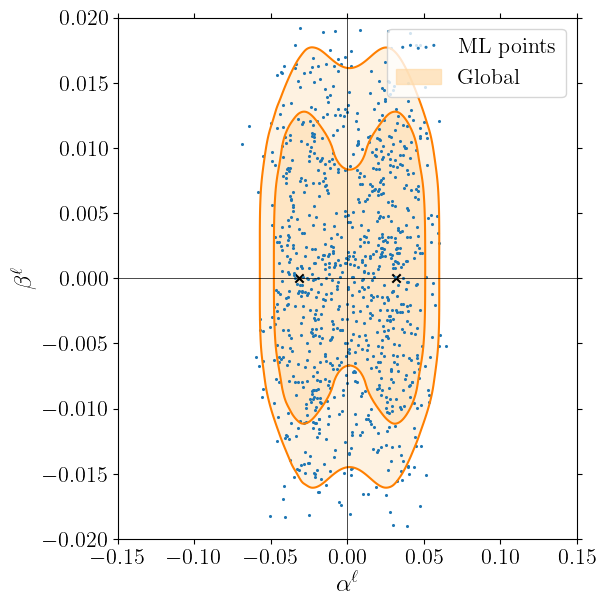

In [43]:
def read_meshgrid_albl(par_x, par_y, n=30):
    index_x = coefs.index(par_x)
    index_y = coefs.index(par_y)
    xcoords = np.linspace(-0.07, 0.07, n)
    ycoords = np.linspace(-0.04, 0.04, n)
    glob = pd.read_csv(f"../data/likelihood/likelihood_rotBII_{par_x}{par_y}.dat", sep = '\t', header=None).values.T
    return (xcoords, ycoords, {'Global': glob})

fig = likelihood_plot2(read_meshgrid_albl('al', 'bl', n=50), mlpoints['al'], mlpoints['bl'],
                dim_min[1], dim_max[1], dim_min[2], dim_max[2], [r'$\alpha^\ell$', r'$\beta^\ell$'], locleg='upper right',
                colors=[4], bf=([bf1[1], bf1[2]], [-bf1[1], bf1[2]]),
                widths=[1.5,]*5, ticks=(0.05, 0.005), fout='../data/plots/ml_albl_global')

linewidths is ignored by contourf


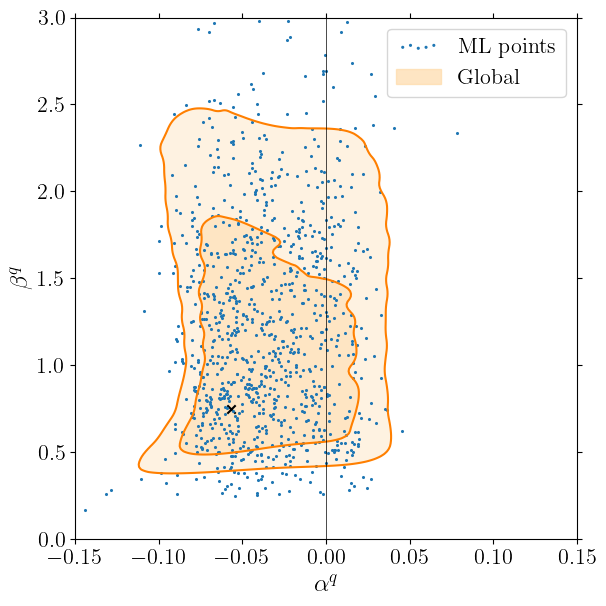

In [53]:
def read_meshgrid_aqbq(par_x, par_y, n=30):
    index_x = coefs.index(par_x)
    index_y = coefs.index(par_y)
    xcoords = np.linspace(-0.15, 0.07, n)
    ycoords = np.linspace(-0.7, 3.0, n)
    glob = pd.read_csv(f"../data/likelihood/likelihood_rotBII_{par_x}{par_y}.dat", sep = '\t', header=None).values.T
    return (xcoords, ycoords, {'Global': glob})

likelihood_plot2(read_meshgrid_aqbq('aq', 'bq', n=50), mlpoints['aq'], mlpoints['bq'],
                dim_min[3], dim_max[3], dim_min[4], dim_max[4], [r'$\alpha^q$', r'$\beta^q$'], locleg='upper right', ticks=(0.05, 0.5),
                colors=[4], bf=[bf1[3], bf1[4]], widths=[1.5,], fout='../data/plots/ml_aqbq_global')

linewidths is ignored by contourf


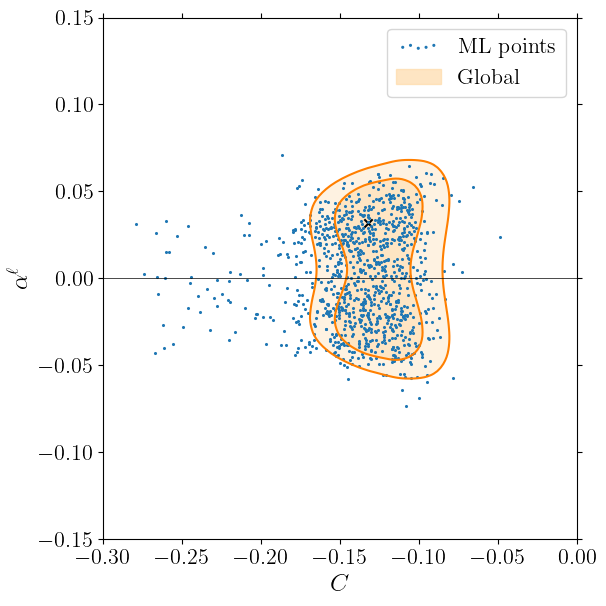

In [28]:
likelihood_plot2(read_meshgrid('C', 'al', n=30), mlpoints['C'], mlpoints['al'],
                -0.3, 0.0, -0.15, 0.15, ['$C$', r'$\alpha^\ell$'], locleg='upper right', ticks=(0.05, 0.05),
                colors=[4], bf=[bf1[0], bf1[1]], widths=[1.5,], fout='../data/plots/ml_Cal_global')

linewidths is ignored by contourf


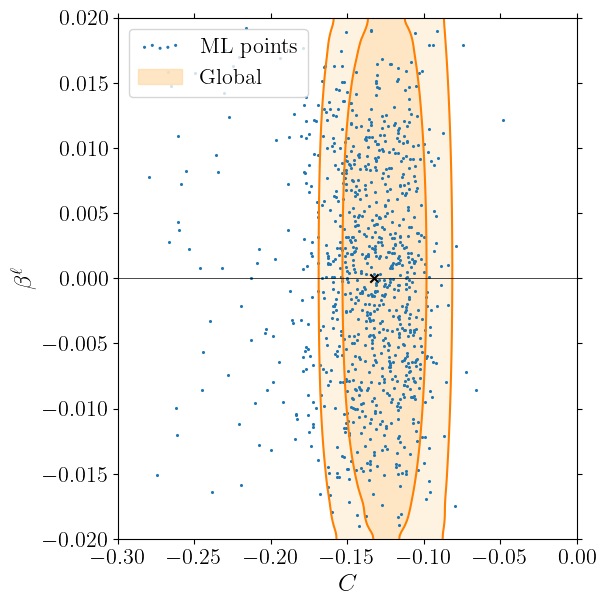

In [29]:
likelihood_plot2(read_meshgrid('C', 'bl', n=30), mlpoints['C'], mlpoints['bl'],
                -0.3, 0.0, -0.02, 0.02, ['$C$', r'$\beta^\ell$'], locleg='upper left', ticks=(0.05, 0.005),
                colors=[4], bf=[bf1[0], bf1[2]], widths=[1.5,], fout='../data/plots/ml_Cbl_global')

linewidths is ignored by contourf


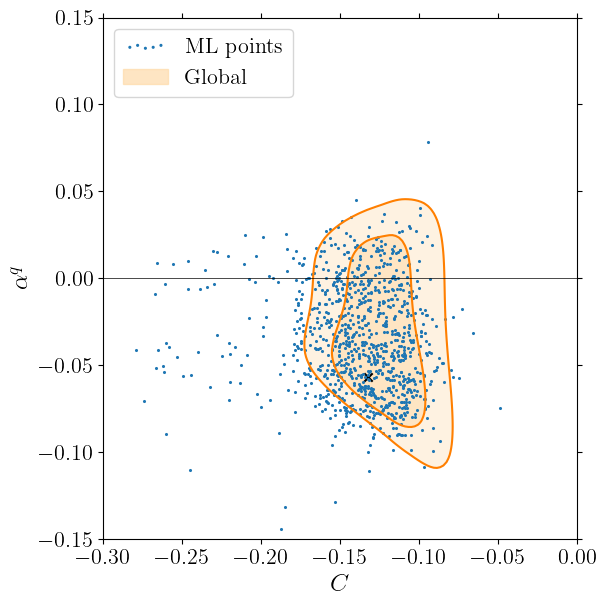

In [30]:
likelihood_plot2(read_meshgrid('C', 'aq'), mlpoints['C'], mlpoints['aq'],
                -0.3, 0.0, -0.15, 0.15, ['$C$', r'$\alpha^q$'], locleg='upper left', ticks=(0.05, 0.05),
                colors=[4], bf=[bf1[0], bf1[3]], widths=[1.5,], fout='../data/plots/ml_Caq_global')

linewidths is ignored by contourf


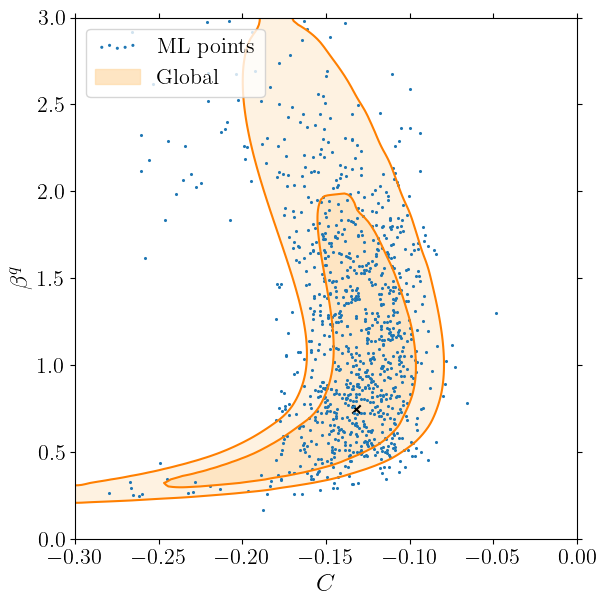

In [10]:
likelihood_plot2(read_meshgrid('C', 'bq'), mlpoints['C'], mlpoints['bq'],
                -0.3, 0.0, 0.0, 3.0, ['$C$', r'$\beta^q$'], locleg='upper left', ticks=(0.05, 0.5),
                colors=[4], bf=[bf1[0], bf1[4]], widths=[1.5,], fout='../data/plots/ml_Cbq_global')

linewidths is ignored by contourf


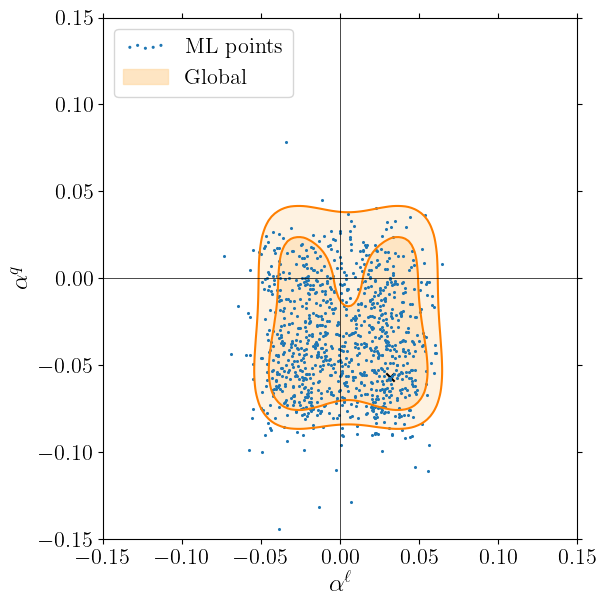

In [32]:
likelihood_plot2(read_meshgrid('al', 'aq'), mlpoints['al'], mlpoints['aq'],
                -0.15, 0.15, -0.15, 0.15, [r'$\alpha^\ell$', r'$\alpha^q$'], locleg='upper left', ticks=(0.05, 0.05),
                colors=[4], bf=[bf1[1], bf1[3]], widths=[1.5,], fout='../data/plots/ml_alaq_global')

linewidths is ignored by contourf


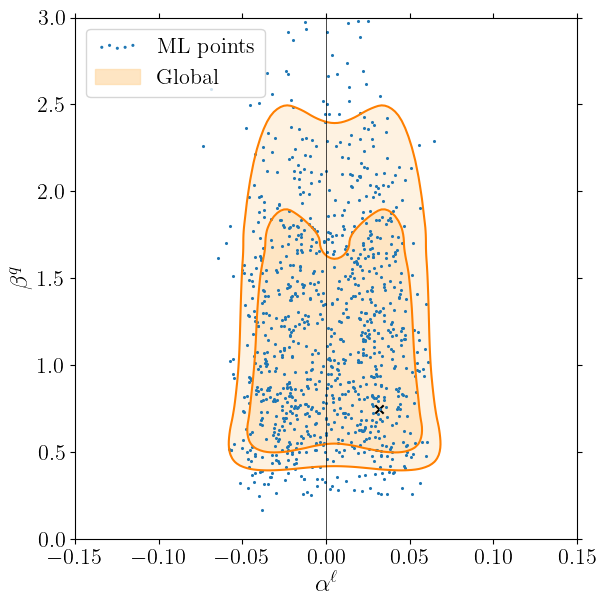

In [33]:
likelihood_plot2(read_meshgrid('al', 'bq'), mlpoints['al'], mlpoints['bq'],
                -0.15, 0.15, 0.0, 3.0, [r'$\alpha^\ell$', r'$\beta^q$'], locleg='upper left', ticks=(0.05, 0.5),
                colors=[4], bf=[bf1[1], bf1[4]], widths=[1.5,], fout='../data/plots/ml_albq_global')

linewidths is ignored by contourf


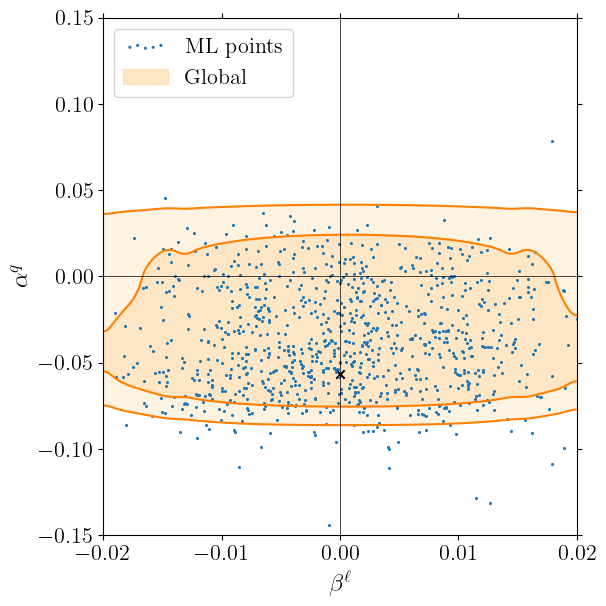

In [34]:
likelihood_plot2(read_meshgrid('bl', 'aq'), mlpoints['bl'], mlpoints['aq'],
                -0.02, 0.02, -0.15, 0.15, [r'$\beta^\ell$', r'$\alpha^q$'], locleg='upper left', ticks=(0.01, 0.05),
                colors=[4], bf=[bf1[2], bf1[3]], widths=[1.5,], fout='../data/plots/ml_blaq_global')

linewidths is ignored by contourf


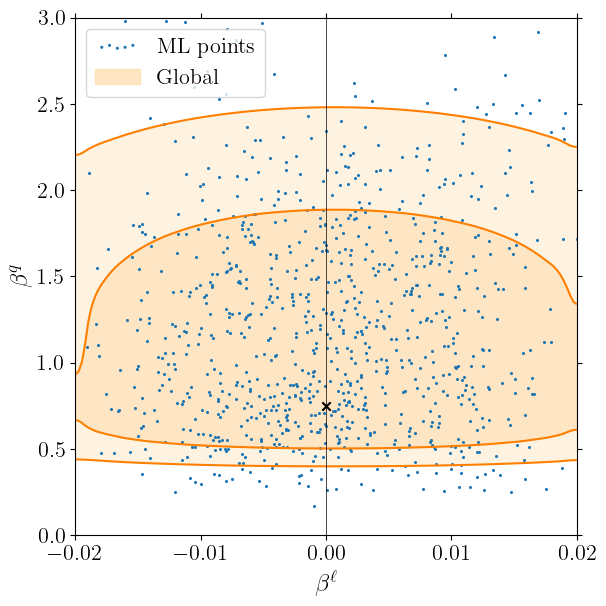

In [35]:
likelihood_plot2(read_meshgrid('bl', 'bq'), mlpoints['bl'], mlpoints['bq'],
                -0.02, 0.02, 0.0, 3.0, [r'$\beta^\ell$', r'$\beta^q$'], locleg='upper left', ticks=(0.01, 0.5),
                colors=[4], bf=[bf1[2], bf1[4]], widths=[1.5,], fout='../data/plots/ml_blbq_global')

### Using subplots

In [64]:
def hatch_contour_sub(fig, ax, x, y, z, levels, interpolation_factor=1, interpolation_order=2, col=0,
                  label=None, hatched=True, contour_args=None, contourf_args=None):
    r"""
Plots coloured and hatched confidence contours (or bands) given numerical
input arrays.Based on the `flavio` function
:Arguments:
    - x, y\: 2D arrays containg x and y values as returned by numpy.meshgrid
    - z\: value of the function to plot. 2D array in the same shape as `x` and
      `y`. The lowest value of the function should be 0 (i.e. the best fit point).
    - levels\: list of function values where to draw the contours. They should
      be positive and in ascending order.
    - [interpolation factor\:: in between the points on the grid,
      the functioncan be interpolated to get smoother contours.
      This parameter sets the number of subdivisions (default: 1, i.e. no
      interpolation). It should be larger than 1.]
    - [col\: number between 0 and 9 to choose the color of the plot
      from a predefined palette.]
    - [label\: label that will be added to a legend created with `maplotlib.pyplot.legend()`.]
    - [contour_args\: dictionary of additional options that will be passed to
      `matplotlib.pyplot.contour()` (that draws the contour lines).]
    - [contourf_args\: dictionary of additional options that will be passed to
      `matplotlib.pyplot.contourf()` (that paints the contour filling).]
    """
    contour_args = contour_args or {}
    contourf_args = contour_args or {}
    if interpolation_factor > 1:
        x = scipy.ndimage.zoom(x, zoom=interpolation_factor, order=1)
        y = scipy.ndimage.zoom(y, zoom=interpolation_factor, order=1)
        z = scipy.ndimage.zoom(z, zoom=interpolation_factor, order=interpolation_order)
    if isinstance(col, int):
        _contour_args = {}
        _contourf_args = {}
        _contour_args['colors'] = [flavio.plots.colors.set1[col]]
        _contour_args['linewidths'] = 1.2
        N = len(levels)
        _contourf_args['colors'] = [flavio.plots.colors.pastel[col] +
                                    (max(1-n/(N+1), 0),) for n in range(1, N+1)]
    else:
        _contour_args = {}
        _contourf_args = {}
        _contour_args['colors'] = [darken_color(matplotlib.colors.to_rgb(col), 0.7)]
        _contour_args['linewidths'] = 1.2
        N = len(levels)
        _contourf_args['colors'] = [matplotlib.colors.to_rgb(col) +
                                    (max(1-n/(N+1), 0),) for n in range(1, N+1)]

    if hatched:
        hl = []
        for i in range(0, N):
            hl.append(hatches[col]*(N-i))
        hl.append(None)
        _contourf_args['hatches'] = hl
    _contour_args['linestyles'] = 'solid'
    _contour_args.update(contour_args)
    _contourf_args.update(contourf_args)
    # for the filling, need to add zero contour
    levelsf = [np.min(z)] + list(levels)
    CF = ax.contourf(x, y, z, levels=levelsf, **_contourf_args)
    CS = ax.contour(x, y, z, levels=levels, **_contour_args)
    if label is not None:
        patch_legend = Patch(color = _contourf_args['colors'][0], label=label)
    else:
        patch_legend = None
    return patch_legend

def likelihood_plot_subs(fig, ax, grid, scatterx, scattery, xmin, xmax, ymin, ymax, axlabels, fout=None, locleg=0, n_sigma=(1, 2),
                    colors=None, styles=None, widths=None, ticks=0.5, bf=None):
    r'''
Plots a contour plot of the log-likelihood of the fit.
:Arguments:
    - grid\: List containing the x coordinates, y coordinates
      and a dictionary for the likelihood values in the grid.
    - xmin\: Minimum value of the `x` coordinate.
    - xmax\: Maximum value of the `x` coordinate.
    - ymin\: Minimum value of the `y` coordinate.
    - ymax\: Maximum value of the `y` coordinate.
    - axlabels\: List containing two strings to label the `x` and `y` axes.
    - [fout\: Path to the files where the plots will be saved.
      Two files are created, one `.pdf` and one `.pgf` (to use in TeX).
      Extensions are added automatically.]
    - [locleg\: Position of the legend of the plot, using `matplotlib`'s syntax.
      Default=0 (best position).]
    - [n_sigma\: List containing the significance (in sigmas) of each contour. Default = (1,2).]
    - [colors\: List with the colors of each contour. Default: flavio palette.]
    - [styles\: List with the linestyles of each contour. Default: All solid.]
    - [widths\: List with the linewidths of each contour. Default: All 1pt.]
    - [ticks\: Interval between ticks in both axes. Default:0.5]
    - [bf\: Coordinates of the best fit point(s). It can be `None` (no point marked)
      or a list containing two floats (one point marked). Default: `None`.]
    '''

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    nfits = len(grid[2])
    if colors is None:
        _cols = [i%9 for i in range(nfits)]
    else:
        _cols = colors
    if styles is None:
        lstyle = ['solid',]*nfits
    else:
        lstyle = styles
    if widths is None:
        lwidths = [1,]*nfits
    else:
        lwidths = widths
    x = grid[0]
    y = grid[1]
    zl = grid[2]
    if axlabels[0] == "$C$" and axlabels[1] == r'$\beta^q$':
        patches = [ax.scatter([], [], s=1.5, label="ML points", c="tab:blue")]
    else:
        patches = None
    for i, z in enumerate(zl.values()):
        chi = -2*(z.T-np.max(z))
        # get the correct values for 2D confidence/credibility contours for n sigma
        if isinstance(n_sigma, float) or isinstance(n_sigma, int):
            levels = [delta_chi2(n_sigma, dof=2)]
        else:
            levels = [delta_chi2(n, dof=2) for n in n_sigma]
        p = hatch_contour_sub(fig, ax, x=x, y=y, z=chi, levels=levels, col=_cols[i], label=list(zl.keys())[i],
                      interpolation_factor=5, hatched=False,
                      contour_args={'linestyles':lstyle[i], 'linewidths':lwidths[i]})
        if p is not None and axlabels[0] == "$C$" and axlabels[1] == r'$\beta^q$':
            patches.append(p)
    if bf is not None:
        for p in listpoint(bf):
            ax.scatter(*p, marker='x', color='black')
    ax.scatter(scatterx, scattery, s=1.5, c="tab:blue")
    if axlabels[1] == r'$\beta^q$':
        ax.set_xlabel(axlabels[0], fontsize=18)
    if axlabels[0] == "$C$":
        ax.set_ylabel(axlabels[1], fontsize=18)
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    #ax = fig.gca()
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    if isinstance(ticks, float):
        xticks = ticks
        yticks = ticks
    else:
        xticks = ticks[0]
        yticks = ticks[1]
    ax.xaxis.set_ticks(np.arange(xmin, xmax+1e-5, xticks))
    ax.yaxis.set_ticks(np.arange(ymin, ymax+1e-5, yticks))
    #ax.set_xticks(fontsize=16)
    #ax.set_yticks(fontsize=16)
    return patches

linewidths is ignored by contourf
linewidths is ignored by contourf
linewidths is ignored by contourf
linewidths is ignored by contourf
linewidths is ignored by contourf
linewidths is ignored by contourf
linewidths is ignored by contourf
linewidths is ignored by contourf
linewidths is ignored by contourf
linewidths is ignored by contourf


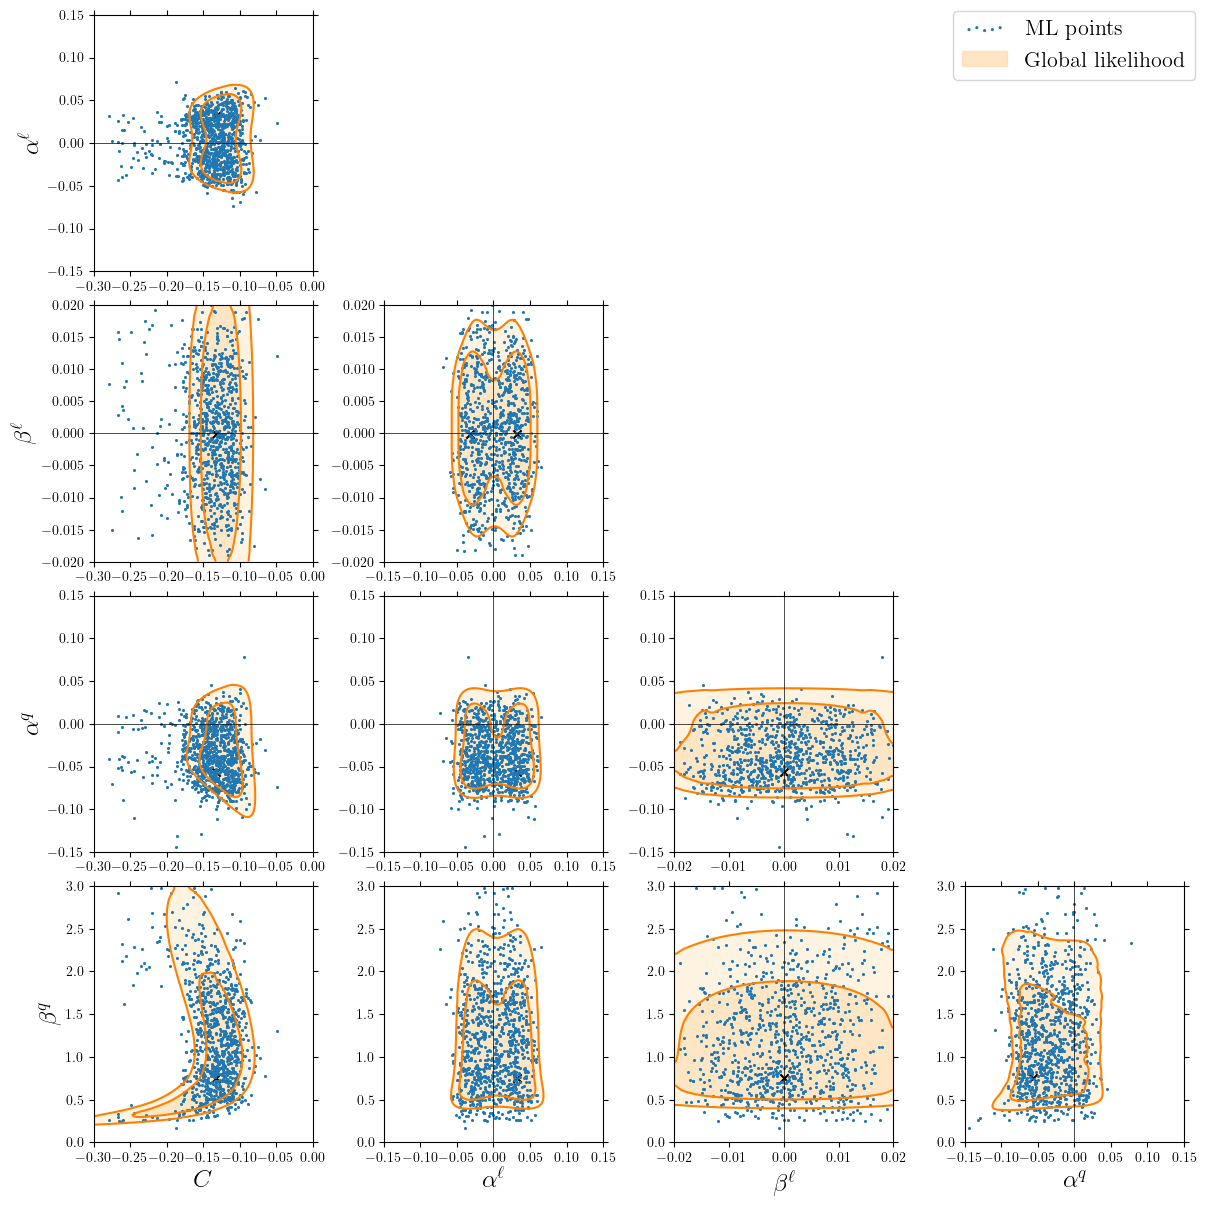

In [73]:
fig, ax = plt.subplots(4, 4, figsize=(12,12))

likelihood_plot_subs(fig, ax[0][0], read_meshgrid('C', 'al', n=30), mlpoints['C'], mlpoints['al'],
                -0.3, 0.0, -0.15, 0.15, ['$C$', r'$\alpha^\ell$'], locleg='upper right', ticks=(0.05, 0.05),
                colors=[4], bf=[bf1[0], bf1[1]], widths=[1.5,], fout='../data/plots/ml_Cal_global')

likelihood_plot_subs(fig, ax[1][0], read_meshgrid('C', 'bl', n=30), mlpoints['C'], mlpoints['bl'],
                -0.3, 0.0, -0.02, 0.02, ['$C$', r'$\beta^\ell$'], locleg='upper left', ticks=(0.05, 0.005),
                colors=[4], bf=[bf1[0], bf1[2]], widths=[1.5,], fout='../data/plots/ml_Cbl_global')

likelihood_plot_subs(fig, ax[1][1], read_meshgrid_albl('al', 'bl', n=50), mlpoints['al'], mlpoints['bl'],
                dim_min[1], dim_max[1], dim_min[2], dim_max[2], [r'$\alpha^\ell$', r'$\beta^\ell$'], locleg='upper right',
                colors=[4], bf=([bf1[1], bf1[2]], [-bf1[1], bf1[2]]),
                widths=[1.5,]*5, ticks=(0.05, 0.005), fout='../data/plots/ml_albl_global')

likelihood_plot_subs(fig, ax[2][0], read_meshgrid('C', 'aq'), mlpoints['C'], mlpoints['aq'],
                -0.3, 0.0, -0.15, 0.15, ['$C$', r'$\alpha^q$'], locleg='upper left', ticks=(0.05, 0.05),
                colors=[4], bf=[bf1[0], bf1[3]], widths=[1.5,], fout='../data/plots/ml_Caq_global')

likelihood_plot_subs(fig, ax[2][1], read_meshgrid('al', 'aq'), mlpoints['al'], mlpoints['aq'],
                -0.15, 0.15, -0.15, 0.15, [r'$\alpha^\ell$', r'$\alpha^q$'], locleg='upper left', ticks=(0.05, 0.05),
                colors=[4], bf=[bf1[1], bf1[3]], widths=[1.5,], fout='../data/plots/ml_alaq_global')

likelihood_plot_subs(fig, ax[2][2], read_meshgrid('bl', 'aq'), mlpoints['bl'], mlpoints['aq'],
                -0.02, 0.02, -0.15, 0.15, [r'$\beta^\ell$', r'$\alpha^q$'], locleg='upper left', ticks=(0.01, 0.05),
                colors=[4], bf=[bf1[2], bf1[3]], widths=[1.5,], fout='../data/plots/ml_blaq_global')

patches = likelihood_plot_subs(fig, ax[3][0], read_meshgrid('C', 'bq'), mlpoints['C'], mlpoints['bq'],
                -0.3, 0.0, 0.0, 3.0, ['$C$', r'$\beta^q$'], locleg='upper left', ticks=(0.05, 0.5),
                colors=[4], bf=[bf1[0], bf1[4]], widths=[1.5,], fout='../data/plots/ml_Cbq_global')

likelihood_plot_subs(fig, ax[3][1], read_meshgrid('al', 'bq'), mlpoints['al'], mlpoints['bq'],
                -0.15, 0.15, 0.0, 3.0, [r'$\alpha^\ell$', r'$\beta^q$'], locleg='upper left', ticks=(0.05, 0.5),
                colors=[4], bf=[bf1[1], bf1[4]], widths=[1.5,], fout='../data/plots/ml_albq_global')

likelihood_plot_subs(fig, ax[3][2], read_meshgrid('bl', 'bq'), mlpoints['bl'], mlpoints['bq'],
                -0.02, 0.02, 0.0, 3.0, [r'$\beta^\ell$', r'$\beta^q$'], locleg='upper left', ticks=(0.01, 0.5),
                colors=[4], bf=[bf1[2], bf1[4]], widths=[1.5,], fout='../data/plots/ml_blbq_global')

likelihood_plot_subs(fig, ax[3][3], read_meshgrid_aqbq('aq', 'bq', n=50), mlpoints['aq'], mlpoints['bq'],
                dim_min[3], dim_max[3], dim_min[4], dim_max[4], [r'$\alpha^q$', r'$\beta^q$'], locleg='upper right', ticks=(0.05, 0.5),
                colors=[4], bf=[bf1[3], bf1[4]], widths=[1.5,], fout='../data/plots/ml_aqbq_global')

fig.legend(handles = patches, loc="upper right", fontsize=16, scatterpoints=5)

fig.delaxes(ax[0][1])
fig.delaxes(ax[0][2])
fig.delaxes(ax[0][3])
fig.delaxes(ax[1][2])
fig.delaxes(ax[1][3])
fig.delaxes(ax[2][3])
fig.tight_layout(pad=0.5)

fig.savefig("../data/plots/ml_all.pdf")

## Extracting the polygons for the likelihood areas

In [38]:
def extract_polygon(grid, n_sigma: float):
    x = grid[0]
    y = grid[1]
    z = grid[2]
    chi = -2*(z.T-np.max(z))
    # get the correct values for 2D confidence/credibility contours for n sigma
    levels = [delta_chi2(n_sigma, dof=2)]
    CS = plt.contour(x, y, chi, levels)
    return CS

def point_in_polygon(polygon, point):
    """
    Raycasting Algorithm to find out whether a point is in a given polygon.
    Performs the even-odd-rule Algorithm to find out whether a point is in a given polygon.
    This runs in O(n) where n is the number of edges of the polygon.
     *
    :param polygon: an array representation of the polygon where polygon[i][0] is the x Value of the i-th point and polygon[i][1] is the y Value.
    :param point:   an array representation of the point where point[0] is its x Value and point[1] is its y Value
    :return: whether the point is in the polygon (not on the edge, just turn < into <= and > into >= for that)
    """

    # A point is in a polygon if a line from the point to infinity crosses the polygon an odd number of times
    odd = False
    # For each edge (In this case for each point of the polygon and the previous one)
    i = 0
    j = len(polygon) - 1
    while i < len(polygon) - 1:
        i = i + 1
        # If a line from the point into infinity crosses this edge
        # One point needs to be above, one below our y coordinate
        # ...and the edge doesn't cross our Y coordinate before our x coordinate (but between our x coordinate and infinity)

        if (((polygon[i][1] > point[1]) != (polygon[j][1] > point[1])) and (point[0] < ( (polygon[j][0] - polygon[i][0]) * (point[1] - polygon[i][1]) / (polygon[j][1] - polygon[i][1])) + polygon[i][0])):
            # Invert odd
            odd = not odd
        j = i
    # If the number of crossings was odd, the point is in the polygon
    return odd

### C al

In [168]:
def read_mesh(fname, stepx=50, stepy=50):
    zdata = pd.read_csv(fname, sep='\t', header=None).to_numpy(dtype=float)
    xcoords = np.linspace(-0.3, 0.0, stepx)
    ycoords = np.linspace(-0.15, 0.15, stepy)
    return (xcoords, ycoords, np.array(zdata.T))

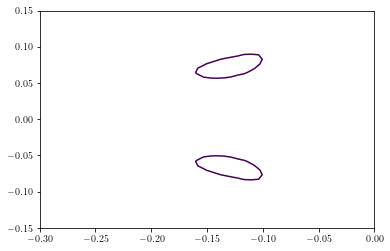

In [169]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_Cal.dat'), 1.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [170]:
inside = 0
for mp in mlpoints.values:
    px = (mp[0], mp[1])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [171]:
inside/len(mlpoints.values)

0.4737631184407796

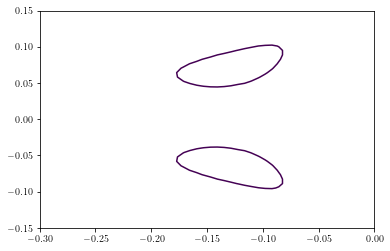

In [172]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_Cal.dat'), 2.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [173]:
inside = 0
for mp in mlpoints.values:
    px = (mp[0], mp[1])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [174]:
inside/len(mlpoints.values)

0.760119940029985

### C bl

In [175]:
def read_mesh(fname, stepx=50, stepy=50):
    zdata = pd.read_csv(fname, sep='\t', header=None).to_numpy(dtype=float)
    xcoords = np.linspace(-0.3, 0.0, stepx)
    ycoords = np.linspace(-0.02, 0.02, stepy)
    return (xcoords, ycoords, np.array(zdata.T))

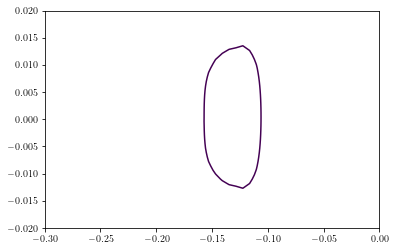

In [176]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_Cbl.dat'), 1.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [177]:
inside = 0
for mp in mlpoints.values:
    px = (mp[0], mp[2])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [178]:
inside/len(mlpoints.values)

0.5142428785607196

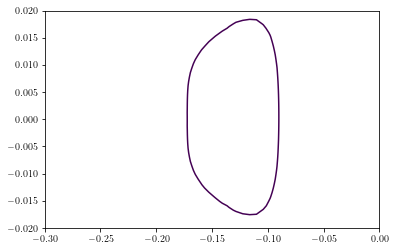

In [179]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_Cbl.dat'), 2.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [180]:
inside = 0
for mp in mlpoints.values:
    px = (mp[0], mp[2])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [181]:
inside/len(mlpoints.values)

0.7856071964017991

### C aq

In [182]:
def read_mesh(fname, stepx=50, stepy=50):
    zdata = pd.read_csv(fname, sep='\t', header=None).to_numpy(dtype=float)
    xcoords = np.linspace(-0.3, 0.0, stepx)
    ycoords = np.linspace(-0.15, 0.15, stepy)
    return (xcoords, ycoords, np.array(zdata.T))

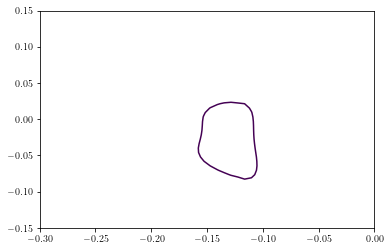

In [183]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_Caq.dat'), 1.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [184]:
inside = 0
for mp in mlpoints.values:
    px = (mp[0], mp[3])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [185]:
inside/len(mlpoints.values)

0.5592203898050975

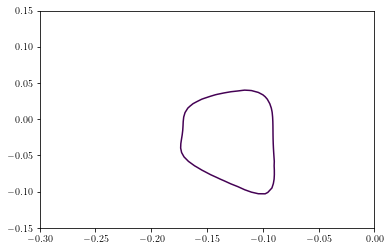

In [186]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_Caq.dat'), 2.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [187]:
inside = 0
for mp in mlpoints.values:
    px = (mp[0], mp[3])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [188]:
inside/len(mlpoints.values)

0.8385807096451774

### C bq

In [189]:
def read_mesh(fname, stepx=50, stepy=50):
    zdata = pd.read_csv(fname, sep='\t', header=None).to_numpy(dtype=float)
    xcoords = np.linspace(-0.3, 0.0, stepx)
    ycoords = np.linspace(0.0, 2.0, stepy)
    return (xcoords, ycoords, np.array(zdata.T))

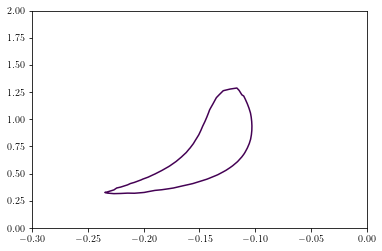

In [190]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_Cbq.dat'), 1.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [191]:
inside = 0
for mp in mlpoints.values:
    px = (mp[0], mp[4])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [192]:
inside/len(mlpoints.values)

0.5432283858070964

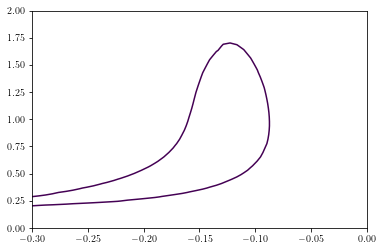

In [193]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_Cbq.dat'), 2.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [194]:
inside = 0
for mp in mlpoints.values:
    px = (mp[0], mp[4])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [195]:
inside/len(mlpoints.values)

0.8505747126436781

### al bl

In [196]:
def read_mesh(fname, stepx=50, stepy=50):
    zdata = pd.read_csv(fname, sep='\t')
    xcoords = np.linspace(zdata['x'].min(), zdata['x'].max(), stepx)
    ycoords = np.linspace(zdata['y'].min(), zdata['y'].max(), stepy)
    fitcodes = {r'$R_{K^{(*)}}$':'likelihood_lfu_fcnc.yaml', r'$R_{D^{(*)}}$':'likelihood_rd_rds.yaml',
                'LFV':'likelihood_lfv.yaml', 'Global':'global'}
    d = {}
    for k, v in zip(fitcodes.keys(), fitcodes.values()):
        z = np.array(zdata[v]).reshape(stepx, stepy)
        d.update({k:z})
    return (xcoords, ycoords, d['Global'])

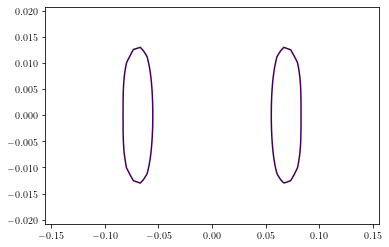

In [197]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_l.dat'), 1.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [199]:
inside = 0
for mp in mlpoints.values:
    px = (mp[1], mp[2])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [200]:
inside/len(mlpoints.values)

0.5822088955522239

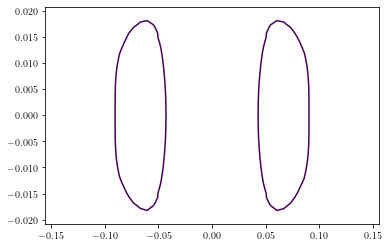

In [201]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_l.dat'), 2.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [202]:
inside = 0
for mp in mlpoints.values:
    px = (mp[1], mp[2])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [203]:
inside/len(mlpoints.values)

0.8445777111444278

### al aq

In [204]:
def read_mesh(fname, stepx=50, stepy=50):
    zdata = pd.read_csv(fname, sep='\t', header=None).to_numpy(dtype=float)
    xcoords = np.linspace(-0.15, 0.15, stepx)
    ycoords = np.linspace(-0.15, 0.15, stepy)
    return (xcoords, ycoords, np.array(zdata.T))

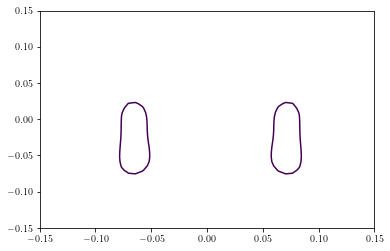

In [205]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_alaq.dat'), 1.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [206]:
inside = 0
for mp in mlpoints.values:
    px = (mp[1], mp[3])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [207]:
inside/len(mlpoints.values)

0.5877061469265368

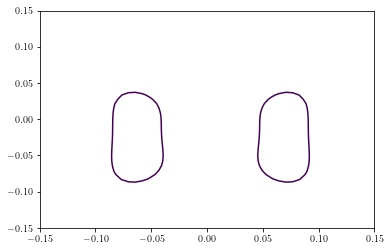

In [208]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_alaq.dat'), 2.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [209]:
inside = 0
for mp in mlpoints.values:
    px = (mp[1], mp[3])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [210]:
inside/len(mlpoints.values)

0.8710644677661169

### al bq

In [211]:
def read_mesh(fname, stepx=50, stepy=50):
    zdata = pd.read_csv(fname, sep='\t', header=None).to_numpy(dtype=float)
    xcoords = np.linspace(-0.15, 0.15, stepx)
    ycoords = np.linspace(0.0, 2.0, stepy)
    return (xcoords, ycoords, np.array(zdata.T))

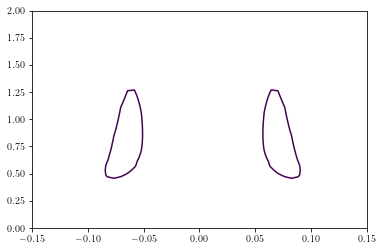

In [212]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_albq.dat'), 1.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [213]:
inside = 0
for mp in mlpoints.values:
    px = (mp[1], mp[4])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [214]:
inside/len(mlpoints.values)

0.47926036981509246

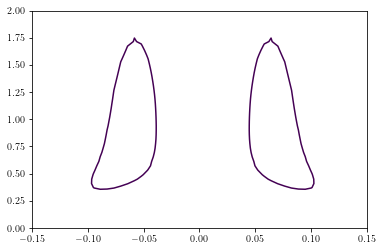

In [215]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_albq.dat'), 2.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [216]:
inside = 0
for mp in mlpoints.values:
    px = (mp[1], mp[4])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [217]:
inside/len(mlpoints.values)

0.800599700149925

### bl aq

In [218]:
def read_mesh(fname, stepx=50, stepy=50):
    zdata = pd.read_csv(fname, sep='\t', header=None).to_numpy(dtype=float)
    xcoords = np.linspace(-0.02, 0.02, stepx)
    ycoords = np.linspace(-0.15, 0.15, stepy)
    return (xcoords, ycoords, np.array(zdata.T))

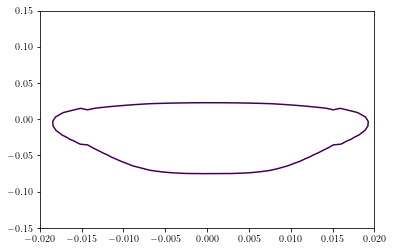

In [219]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_blaq.dat'), 1.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [220]:
inside = 0
for mp in mlpoints.values:
    px = (mp[2], mp[3])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [221]:
inside/len(mlpoints.values)

0.8255872063968016

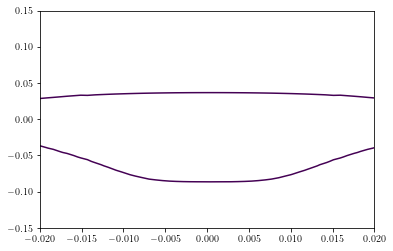

In [222]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_blaq.dat'), 2.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [223]:
inside = 0
for mp in mlpoints.values:
    px = (mp[2], mp[3])
    poly = list(paths[0].vertices[:-1]) + list(paths[1].vertices[:-1])
    inside += int(point_in_polygon(poly, px))

In [224]:
inside/len(mlpoints.values)

0.9260369815092454

### bl bq

In [225]:
def read_mesh(fname, stepx=50, stepy=50):
    zdata = pd.read_csv(fname, sep='\t', header=None).to_numpy(dtype=float)
    xcoords = np.linspace(-0.02, 0.02, stepx)
    ycoords = np.linspace(0, 2.0, stepy)
    return (xcoords, ycoords, np.array(zdata.T))

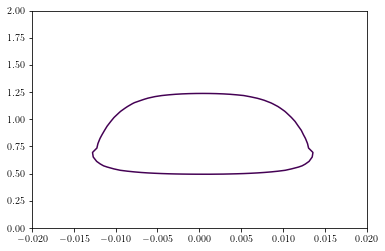

In [226]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_blbq.dat'), 1.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [227]:
inside = 0
for mp in mlpoints.values:
    px = (mp[2], mp[4])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [228]:
inside/len(mlpoints.values)

0.5762118940529735

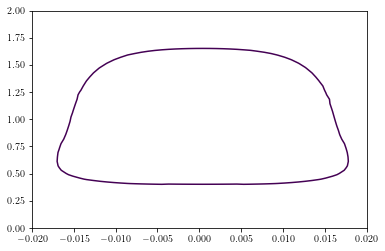

In [229]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_blbq.dat'), 2.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [230]:
inside = 0
for mp in mlpoints.values:
    px = (mp[2], mp[4])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [231]:
inside/len(mlpoints.values)

0.824087956021989

### aq bq

In [145]:
def read_mesh(fname, stepx=50, stepy=50):
    zdata = pd.read_csv(fname, sep='\t')
    xcoords = np.linspace(zdata['x'].min(), zdata['x'].max(), stepx)
    ycoords = np.linspace(zdata['y'].min(), zdata['y'].max(), stepy)
    fitcodes = {r'$R_{K^{(*)}}$':'likelihood_lfu_fcnc.yaml', r'$R_{D^{(*)}}$':'likelihood_rd_rds.yaml',
                'LFV':'likelihood_lfv.yaml', 'Global':'global'}
    d = {}
    for k, v in zip(fitcodes.keys(), fitcodes.values()):
        z = np.array(zdata[v]).reshape(stepx, stepy)
        d.update({k:z})
    return (xcoords, ycoords, d['Global'])

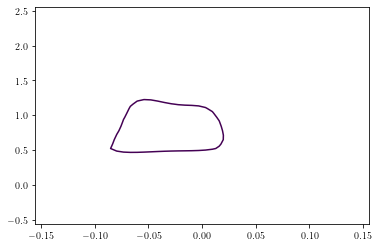

In [146]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_q.dat'), 1.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [147]:
inside = 0
for mp in mlpoints.values:
    px = (mp[3], mp[4])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [148]:
inside/len(mlpoints.values)

0.624687656171914

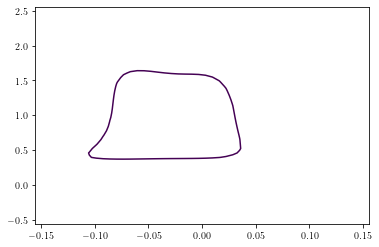

In [149]:
CS = extract_polygon(read_mesh('../data/likelihood/likelihood_rotBII_q.dat'), 2.0)
coll = CS.collections[0]
paths = coll.get_paths()

In [150]:
inside = 0
for mp in mlpoints.values:
    px = (mp[3], mp[4])
    for p in paths:
        poly = p.vertices
        inside += int(point_in_polygon(poly, px))

In [151]:
inside/len(mlpoints.values)

0.9015492253873063